In [1]:
import quandl
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
import sklearn.datasets
import pandas as pd
from sklearn import preprocessing

backwards_points = 75

In [3]:
DJIA_data = quandl.get("BCB/UDJIAD1", start_date="2008-8-8", end_date="2016-7-1")

In [4]:
plot_test = pd.DataFrame(DJIA_data)
plot_test = plot_test.reset_index()
plot_test["Time (Days)"] = np.arange(len(plot_test))
plot_test = plot_test.drop("Date", axis = 1)

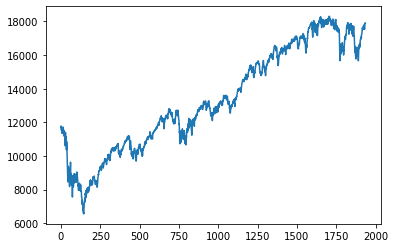

In [5]:
plt.plot(plot_test["Time (Days)"], plot_test["Value"], label='DJIA')

In [6]:
def to_dataset(DJIA_data):
    DJIA_df = pd.DataFrame(DJIA_data)
    DJIA_df = DJIA_df.reset_index()
    DJIA_df = DJIA_df.drop("Date", axis = 1)
    DJIA_df = DJIA_df.values

    DJIA_df_normaliser = preprocessing.MinMaxScaler()
    DJIA_df_normalised = DJIA_df_normaliser.fit_transform(DJIA_df)
    past_values_normalised =  np.array([DJIA_df_normalised[i:i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised =  np.array([DJIA_df_normalised[:,0][i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)

    next_day_values = np.array([DJIA_df[:,0][i + backwards_points].copy() for i in range(len(DJIA_df) - backwards_points)])
    next_day_values = np.expand_dims(next_day_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)
    
    assert past_values_normalised.shape[0] == next_day_values_normalised.shape[0]
    return past_values_normalised, next_day_values_normalised, next_day_values, y_normaliser

In [7]:
past_values, next_day_values, unscaled_y, y_normaliser = to_dataset(DJIA_data)

test_split = 0.8
n = int(past_values.shape[0] * test_split)

X_train = past_values[:n]
y_train = next_day_values[:n]

X_test = past_values[n:]
y_test = next_day_values[n:]

unscaled_y_test = unscaled_y[n:]

print(X_train.shape)
print(X_test.shape)

(1488, 75, 1)
(372, 75, 1)


In [8]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

#https://keras.io/api/layers/recurrent_layers/lstm/

lstm_input = Input(shape = (backwards_points, 1), name="lstm_input")
x = LSTM(75, name = "lstm_0")(lstm_input)
x = Dropout(0.2, name = "lstm_dropout_0")(x)
x = Dense(64, name = "dense_0")(x)
x = Activation("sigmoid", name = "sigmoid_0")(x)
x = Dense(1, name = "dense_1")(x)
output = Activation('linear', name = "linear_output")(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)

Using TensorFlow backend.


Train on 1339 samples, validate on 149 samples
Epoch 1/50
1339/1339 [==============================] - 6s 5ms/step - loss: 0.3933 - val_loss: 0.1275
Epoch 2/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0135 - val_loss: 0.0240
Epoch 3/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 4/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 5/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 7/50
1339/1339 [==============================] - 5s 3ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 8/50
1339/1339 [==============================] - 5s 3ms/step - loss: 0.0026 - val_loss: 4.0207e-04
Epoch 9/50
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0023 - val_loss: 3.3746e-04
Epoch 10/50
1339/1339 [====

In [9]:
y_test_predicted = model.predict(X_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(past_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

3605.9998306469806


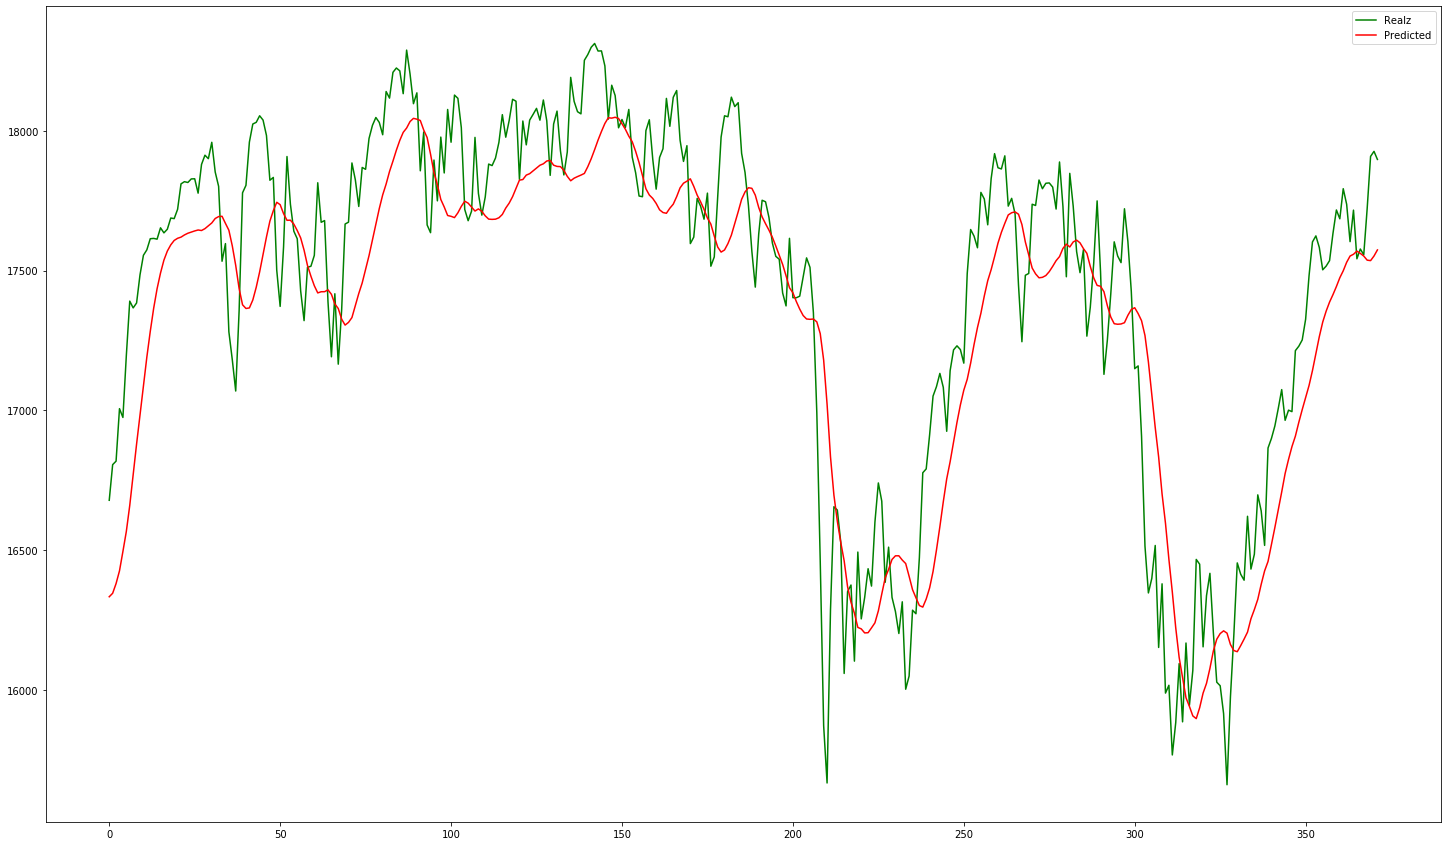

In [10]:
#plt.gcf is get current figure
plt.gcf().set_size_inches(25, 15, forward=True)
plt.plot(unscaled_y_test, label="Real", color="green")
plt.plot(y_test_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])

plt.show()